# How to create map-reduce branches for parallel execution

[Map-reduce](https://en.wikipedia.org/wiki/MapReduce) operations are essential for efficient task decomposition and parallel processing. This approach involves breaking a task into smaller units, processing them concurrently, and aggregating the results. Consider this example: given a general topic, we aim to generate a list of related subjects, generate a joke for each subject, and select the best joke from the resulting list. However, two main challenges arise:

In this design pattern, a first node may generate a list of objects, and you may want to apply some other node to all those objects. (1) 
the number of objects (e.g., subjects) may be unknown ahead of time (meaning the number of edges may not be known) and (2) the input State to the downstream Node should be different (one for each generated object).
  
LangGraph addresses these challenges [through its `Send` API](https://langchain-ai.github.io/langgraph/concepts/low_level/#send). By utilizing conditional edges, `Send` can distribute different states (e.g., subjects) to multiple instances of a node (e.g., joke generation). Importantly, the sent state can differ from the core graph's state, allowing for flexible and dynamic workflow management. 
By leveraging LangGraph's Send API, complex map-reduce operations become more manageable and adaptable to varying task requirements.

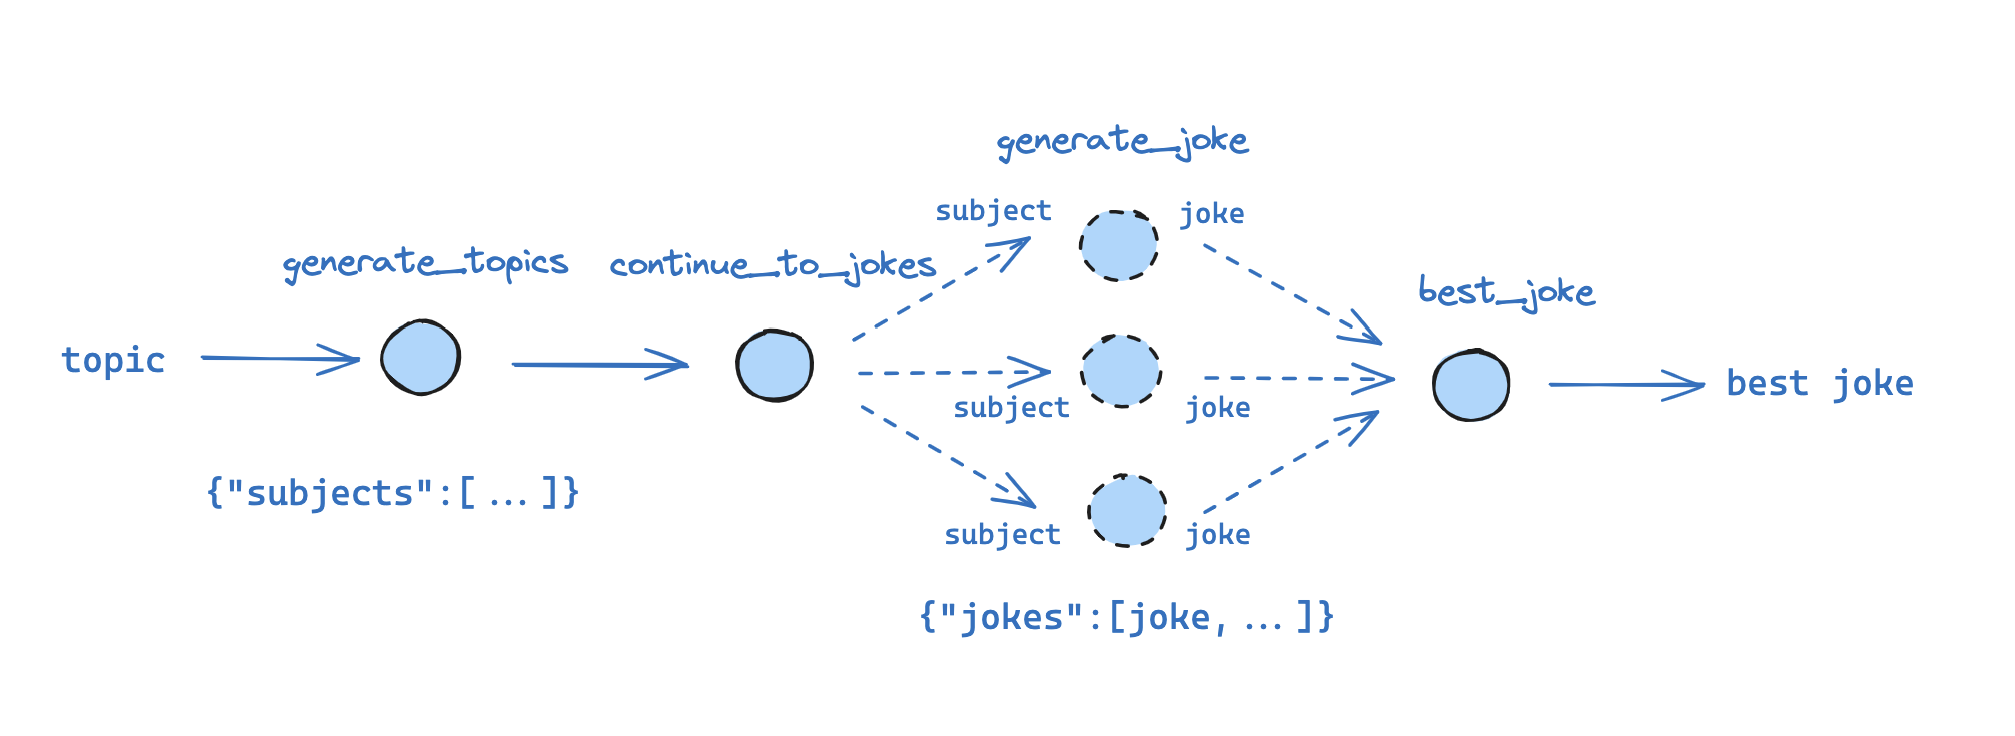

In [ ]:
%%capture --no-stderr
%pip install -U langchain-anthropic langgraph

In [1]:
import os
import getpass


def _set_env(name: str):
    if not os.getenv(name):
        os.environ[name] = getpass.getpass(f"{name}: ")


_set_env("ANTHROPIC_API_KEY")

In [2]:
import operator
from typing import Annotated, TypedDict

from langchain_core.pydantic_v1 import BaseModel
from langchain_anthropic import ChatAnthropic

from langgraph.constants import Send
from langgraph.graph import END, StateGraph, START

# Model and prompts
# Define model and prompts we will use
subjects_prompt = """Generate a comma separated list of between 2 and 5 examples related to: {topic}."""
joke_prompt = """Generate a joke about {subject}"""
best_joke_prompt = """Below are a bunch of jokes about {topic}. Select the best one! Return the ID of the best one.

{jokes}"""


class Subjects(BaseModel):
    subjects: list[str]


class Joke(BaseModel):
    joke: str


class BestJoke(BaseModel):
    id: int


model = ChatAnthropic(model="claude-3-5-sonnet-20240620")

# Graph components: define the components that will make up the graph


# This will be the overall state of the main graph.
# It will contain a topic (which we expect the user to provide)
# and then will generate a list of subjects, and then a joke for
# each subject
class OverallState(TypedDict):
    topic: str
    subjects: list
    # Notice here we use the operator.add
    # This is because we want combine all the jokes we generate
    # from individual nodes back into one list - this is essentially
    # the "reduce" part
    jokes: Annotated[list, operator.add]
    best_selected_joke: str


# This will be the state of the node that we will "map" all
# subjects to in order to generate a joke
class JokeState(TypedDict):
    subject: str


# This is the function we will use to generate the subjects of the jokes
def generate_topics(state: OverallState):
    prompt = subjects_prompt.format(topic=state["topic"])
    response = model.with_structured_output(Subjects).invoke(prompt)
    return {"subjects": response.subjects}


# Here we generate a joke, given a subject
def generate_joke(state: JokeState):
    prompt = joke_prompt.format(subject=state["subject"])
    response = model.with_structured_output(Joke).invoke(prompt)
    return {"jokes": [response.joke]}


# Here we define the logic to map out over the generated subjects
# We will use this an edge in the graph
def continue_to_jokes(state: OverallState):
    # We will return a list of `Send` objects
    # Each `Send` object consists of the name of a node in the graph
    # as well as the state to send to that node
    return [Send("generate_joke", {"subject": s}) for s in state["subjects"]]


# Here we will judge the best joke
def best_joke(state: OverallState):
    jokes = "\n\n".format()
    prompt = best_joke_prompt.format(topic=state["topic"], jokes=jokes)
    response = model.with_structured_output(BestJoke).invoke(prompt)
    return {"best_selected_joke": state["jokes"][response.id]}


# Construct the graph: here we put everything together to construct our graph
graph = StateGraph(OverallState)
graph.add_node("generate_topics", generate_topics)
graph.add_node("generate_joke", generate_joke)
graph.add_node("best_joke", best_joke)
graph.add_edge(START, "generate_topics")
graph.add_conditional_edges("generate_topics", continue_to_jokes, ["generate_joke"])
graph.add_edge("generate_joke", "best_joke")
graph.add_edge("best_joke", END)
app = graph.compile()

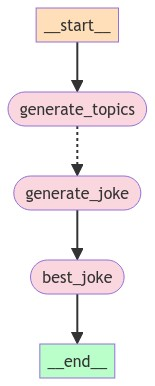

In [3]:
from IPython.display import Image

Image(app.get_graph().draw_mermaid_png())

In [4]:
# Call the graph: here we call it to generate a list of jokes
for s in app.stream({"topic": "animals"}):
    print(s)

{'generate_topics': {'subjects': ['lion', 'elephant', 'penguin', 'giraffe']}}
{'generate_joke': {'jokes': ["Why don't you see penguins in Britain? Because they're afraid of Wales!"]}}
{'generate_joke': {'jokes': ["Why don't elephants use computers? They're afraid of the mouse!"]}}
{'generate_joke': {'jokes': ["Why don't lions like fast food? Because they can't catch it!"]}}
{'generate_joke': {'jokes': ["Why don't giraffes ever get caught in traffic jams? Because they can always stick their necks out and see what's ahead!"]}}
{'best_joke': {'best_selected_joke': "Why don't elephants use computers? They're afraid of the mouse!"}}
